# Predict TripAdvisor Rating

### Подключение библиотек и загрузка наборов данных

In [68]:
import numpy as np
import pandas as pd 
from scipy.stats import chi2_contingency
from scipy.stats import lognorm
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модел
from sklearn import preprocessing
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
import os
for dirname, _, filenames in os.walk('/home/stormrider/Desktop/Python/Kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/stormrider/Desktop/Python/Kaggle/main_task.csv
/home/stormrider/Desktop/Python/Kaggle/SF TripAdvisor Rating [AndrewLitvinov].ipynb
/home/stormrider/Desktop/Python/Kaggle/SF TripAdvisor Rating [AndrewLitvinov] v2.ipynb
/home/stormrider/Desktop/Python/Kaggle/submission.csv
/home/stormrider/Desktop/Python/Kaggle/sample_submission.csv
/home/stormrider/Desktop/Python/Kaggle/requirements.txt
/home/stormrider/Desktop/Python/Kaggle/kaggle_task.csv
/home/stormrider/Desktop/Python/Kaggle/.ipynb_checkpoints/SF TripAdvisor Rating [AndrewLitvinov] v2-checkpoint.ipynb
/home/stormrider/Desktop/Python/Kaggle/.ipynb_checkpoints/SF TripAdvisor Rating [AndrewLitvinov]-checkpoint.ipynb


In [69]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

In [70]:
#DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
DATA_DIR = '/home/stormrider/Desktop/Python/Kaggle/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [71]:
# Функции
def get_plot(column):
    """Вывод графика"""
    plt.figure(figsize=(14, 14))
    column.value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Number of observations')
    plt.show()


def null_count(column):
    """Вывод информации о количестве пропущенных значений"""

    print(' Кол-во наблюдений:', column.isnull().count(), '\n',
          'Кол-во пропущенных значений:', column.isnull().sum(), '\n',
          'Процент пропущенных значений:',
          int(round(column.isnull().sum()/column.isnull().count()*100, 0)), '%', '\n',
          'Кол-во уникальных значений:', column.nunique())

Тренировочный набор данных

In [72]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [73]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


Тестовый набор данных

In [74]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [75]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


Для корректной обработки признаков объединяем тренировочный и тестовый наборы данных в один датасет

In [76]:
df_train['sample'] = 1  # помечаем где у нас тренировочный датасет
df_test['sample'] = 0  # помечаем где у нас тестовый датасет
# В тестовом наборе данных нет значения Rating.
# Мы его должны предсказать, по этому пока просто заполняем нулями.
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True)

Подробнее по признакам:
* Restaurant_id: ID ресторана в наборе данных
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана, целевой параметр

## 1 EDA

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


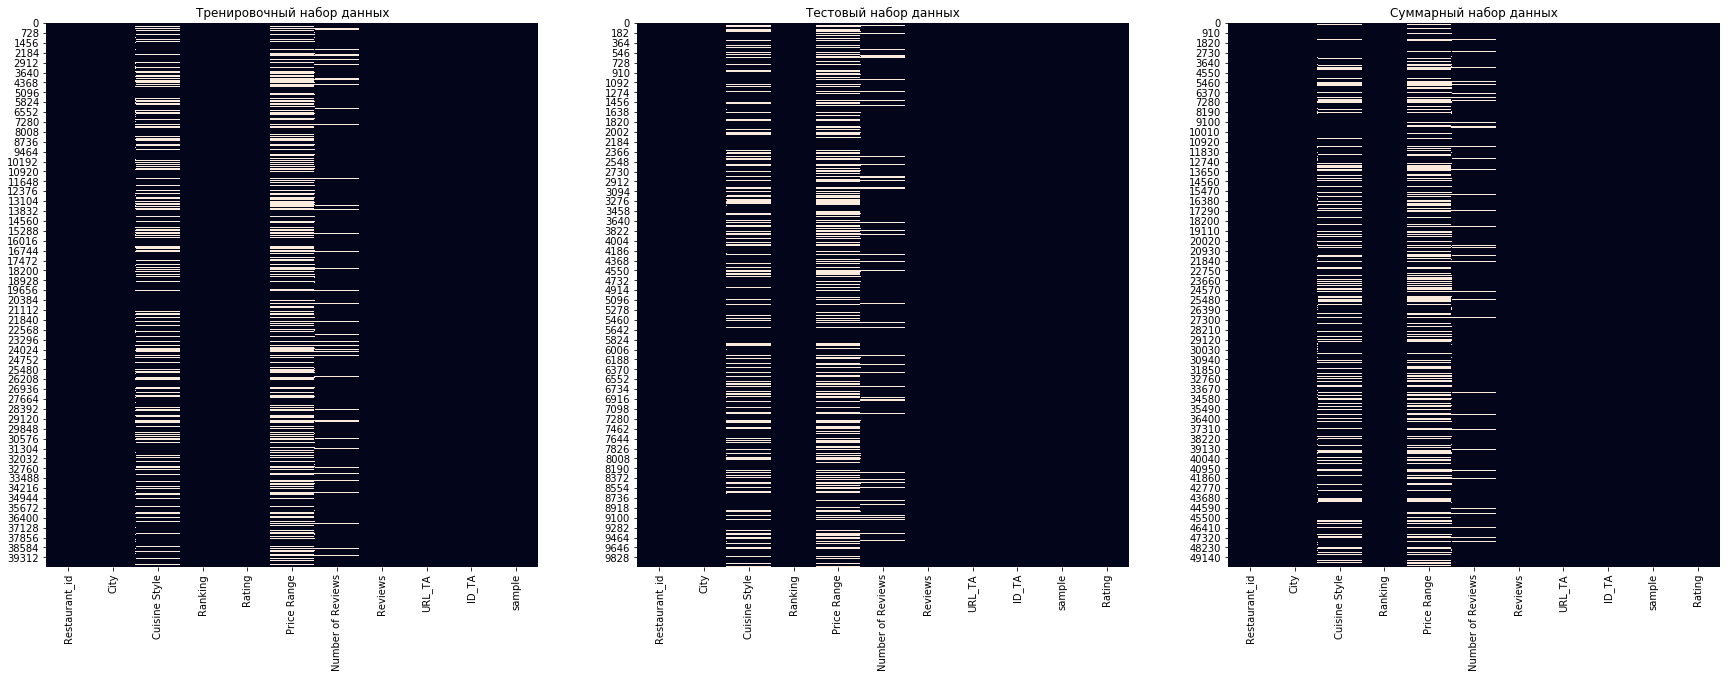

In [78]:
fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.set_title('Тренировочный набор данных')
sns.heatmap(data=df_train.isnull(), cbar=False, ax=ax1)
ax2.set_title('Тестовый набор данных')
sns.heatmap(data=df_test.isnull(), cbar=False, ax=ax2)
ax3.set_title('Суммарный набор данных')
sns.heatmap(data=data.isnull(), cbar=False, ax=ax3)

Как видно из графиков, пропущенные значения тренировочного, тестового и, как следствие, суммарного наборов данных наблюдаются в одних и тех же параметрах Cuisine Style, Price Range, Number of Reviews. Признаки Cuisine Style и Price Range содержат большое количество пропущенных значений. В параметре Reviews всего два пропущенных значения.

Проверим наличие дубликатов в наборе данных

In [79]:
data = data.drop_duplicates(keep="first").reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Как видно, все наблюдения уникальны, на первый взгляд.

### Рассмотрим подробнее признаки суммарного набора данных.

### 1.1 Restaurant_id

In [80]:
null_count(data.Restaurant_id)

 Кол-во наблюдений: 50000 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 13094


Значения параметра не уникальны, повторяются.Т.к. количество значений очень велико, посмотрим, как распределено количество повторений значений признака Restaurant_id

<BarContainer object of 19 artists>

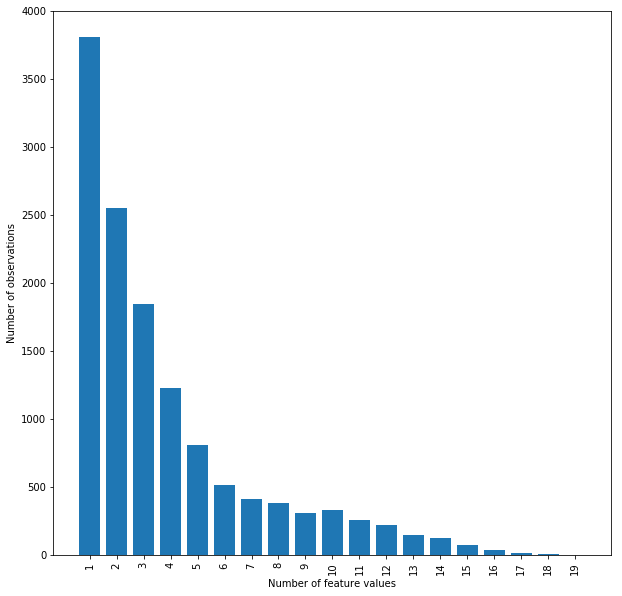

In [81]:
res_id_dict = {}
for id_count in data.Restaurant_id.value_counts().tolist():
    if id_count not in res_id_dict:
        res_id_dict[id_count] = 1
    else:
        res_id_dict[id_count] += 1
plt.figure(figsize=(10, 10))
plt.xticks(ticks=data.Restaurant_id.value_counts().unique(), rotation=90)
plt.ylabel('Number of observations')
plt.xlabel('Number of feature values')
plt.bar(x=res_id_dict.keys(), height=res_id_dict.values())

Как видно из графика, id ресторанов повторяются: максимальное количество повторений - 19 раз. Посмотрим наблюдения с Restuarant_id, значение которого повторилось несколько раз, например, 19 раз.

In [82]:
display(data[data.Restaurant_id==data.Restaurant_id.value_counts().index[0]])

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
871,id_871,Berlin,NaN,5900.0,NaN,5.0,"[[], []]",/Restaurant_Review-g187323-d10057590-Reviews-K...,d10057590,0,0.0
10756,id_871,Milan,"['Chinese', 'Seafood', 'Vegetarian Friendly']",873.0,$$ - $$$,69.0,"[['My favourite Chinese Restaurant in Milan', ...",/Restaurant_Review-g187849-d8277124-Reviews-Ri...,d8277124,1,4.5
11172,id_871,Geneva,['International'],876.0,$$ - $$$,28.0,[['Wild Girls Mess - A place Where Staff igno....,/Restaurant_Review-g188057-d4462793-Reviews-BG...,d4462793,1,4.0
13239,id_871,Zurich,"['Bar', 'Pub']",875.0,NaN,3.0,"[['Schlager central'], ['04/11/2015']]",/Restaurant_Review-g188113-d7904953-Reviews-Pe...,d7904953,1,4.5
14275,id_871,Prague,"['Czech', 'European', 'Eastern European']",872.0,$,66.0,"[['Good food, reasonable prices, Czech beer t....",/Restaurant_Review-g274707-d4767690-Reviews-Re...,d4767690,1,4.5
15350,id_871,Krakow,"['Fast Food', 'European', 'Greek', 'Vegetarian...",872.0,$,98.0,"[['Good and Inexpensive!', 'Terrible service.'...",/Restaurant_Review-g274772-d1098630-Reviews-Ak...,d1098630,1,3.5
19209,id_871,Athens,NaN,873.0,NaN,9.0,"[['Crepexarchia', 'Filling and delicious food ...",/Restaurant_Review-g189400-d10110357-Reviews-C...,d10110357,1,4.5
21434,id_871,Berlin,"['Asian', 'Vegetarian Friendly', 'Gluten Free ...",872.0,$$ - $$$,37.0,"[['Honest, fun and so good!', 'Amazing!!'], ['...",/Restaurant_Review-g187323-d12165690-Reviews-M...,d12165690,1,4.5
30423,id_871,Munich,"['French', 'Mediterranean', 'European', 'Wine ...",879.0,$$$$,87.0,"[['I will go back next time when in Munich', '...",/Restaurant_Review-g187309-d1342532-Reviews-Le...,d1342532,1,4.5
32885,id_871,Barcelona,"['Mediterranean', 'Wine Bar', 'International',...",872.0,$$$$,102.0,"[['Great wine tasting', 'Excellent meal with a...",/Restaurant_Review-g187497-d7332637-Reviews-Bo...,d7332637,1,4.5


Можно предположить, что признак Restaurant_id в определенной степени коррелирует с признаком Price Range.
Преобразуем признак Restaurant_id в числовой вид для удобства обработки.

In [83]:
data.Restaurant_id=data.Restaurant_id.apply(lambda x: int(x[3:]))

### 1.2 City

In [84]:
null_count(data.City)

 Кол-во наблюдений: 50000 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 31


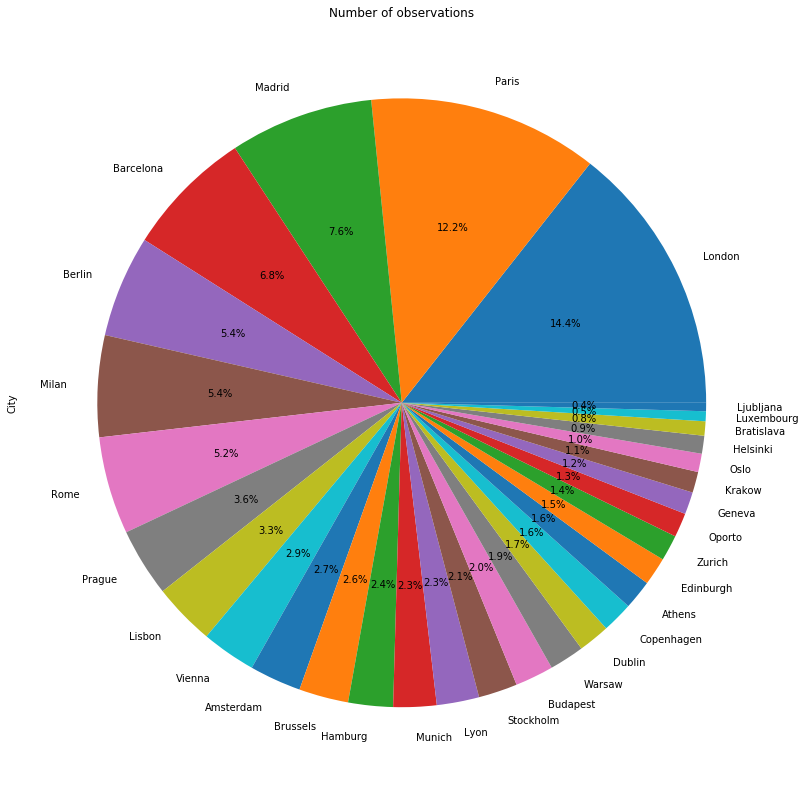

In [85]:
get_plot(data.City)

Наблюдения произведены по европейским городам. Большинство наблюдений сосредоточены среди городов: Лондон, Париж, Мадрид, Барселона, Берлин, Милан и Рим. Наблюдения в данных городах составляют 57% от общего количества наблюдений. Можно отметить, что некоторые города относятся к одной и той же стране: выведем признаки страны местонахождения ресторана, плотность населения в городах, странах.

### 1.3 Cuisine Style

In [86]:
null_count(data['Cuisine Style'])

 Кол-во наблюдений: 50000 
 Кол-во пропущенных значений: 11590 
 Процент пропущенных значений: 23 % 
 Кол-во уникальных значений: 10731


Как видно, вариативность значений признака довольно высока.
Признак содержит 23% пропущенных значений.

In [87]:
data['Cuisine Style'][3]

"['Italian', 'Mediterranean', 'European', 'Vegetarian Friendly', 'Gluten Free Options']"

Каждое наблюдение содрежит несколько типов кухонь. Попробуем сформировать список всех кухонь и посотреть на их количественное распределение.

In [88]:
# Список всех наблюдений
cuisine_list = data['Cuisine Style'].apply(lambda x:
                                           ['Other'] if pd.isnull(x)
                                           else x[2:-2].split('\', \'')).tolist()

# Словарь, содержащий количество всех наблюдаемых значений признака
cuis_dict = {}
for cuisine in cuisine_list:
    for cuis in cuisine:
        if cuis not in cuis_dict:
            cuis_dict[cuis] = 1
        else:
            cuis_dict[cuis] += 1
for cuis in cuis_dict:
    cuis_dict[cuis] = cuis_dict[cuis]/50000

# Значения, составляющие не менее 1% от общего количества наблюдений
cuis_dict_sort = {}
for cuis in cuis_dict:
    if cuis_dict[cuis] >= 0.01:
        cuis_dict_sort[cuis] = cuis_dict[cuis]

<BarContainer object of 44 artists>

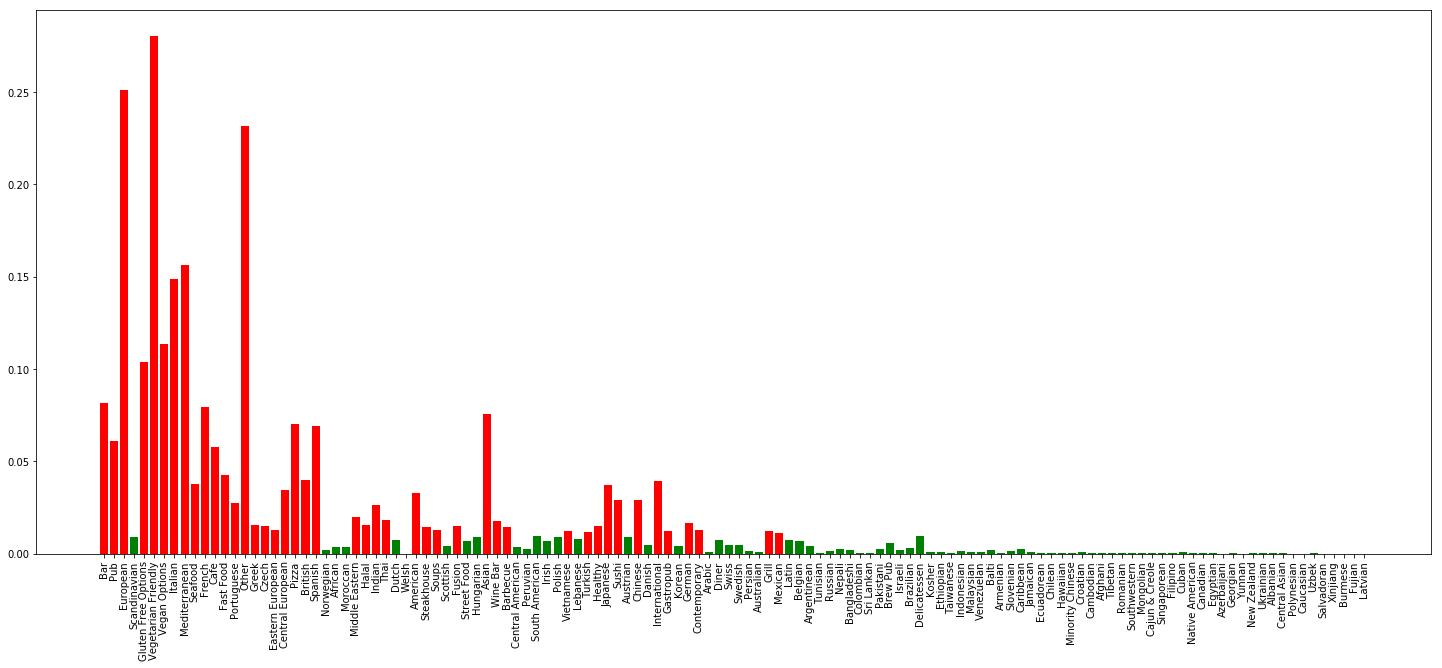

In [89]:
plt.figure(figsize=(25, 10))
plt.xticks(rotation=90)
plt.bar(cuis_dict.keys(), cuis_dict.values(), color='g')
plt.bar(cuis_dict_sort.keys(), cuis_dict_sort.values(), color='r')

Больше всего наблюдений можно отметить по следующим кухням: Bar, Pub, European, Gluten Free Options, Vegetarian Options, Italian, Mediterranean, Seafood, French, Cafe, Fast Food, Portuguese, Greek, Czech, Eastern Europe, Central European, Pizza, British, Spanish, Middle Eastern, Halal, Indian, Thai, American, Steakhouse, Soups, Fusion, Asian, Wine Bar, Barbecue, Vietnamese, Lebanese, Turkish, Healthy, Japanese, Sushi, Chinese, Danish, International, Gastropub, German, Contemporary, Grill, Mexican и Other, значение, обозначающее пропуски в признаке Cuisine Style исходного датафрейма.
Некоторые наблюдения логически связаны, например, South American и Peruvian. Можно связать вместе логически связанные кухни, если они не присутствуют в одном и том же наблюдении.

In [90]:
# Словарь итогового набора значений признака Cuisine Style
cuis_new_dict = {'Europe': 0, 'Mediterranean': 0, 'British': 0, 'American': 0,
                 'Asian': 0, 'Central European': 0, 'Middle Eastern': 0, 'Cafe': 0,
                 'Bar': 0, 'Pub': 0, 'Fast Food': 0, 'Vegetarian Friendly': 0,
                 'Seafood': 0, 'Pizza': 0, 'Vegan Options': 0, 'Gluten Free Options': 0,
                 'Wine Bar': 0, 'Healthy': 0, 'Contemporary': 0, 'Barbecue': 0,
                 'Fusion': 0, 'Grill': 0, 'Italian': 0, 'French': 0, 'Spanish': 0,
                 'Japanese': 0, 'African': 0, 'South American': 0, 'Northern Europe': 0,
                 'Eastern European': 0, 'Caribbean': 0, 'Western Asian': 0,
                 'Central American': 0, 'Central Asian': 0, 'Southern Asia': 0,
                 'Southeastern Asia': 0, 'Eastern Asia': 0, 'Chinese': 0, 'Southern Europe': 0,
                 'Polynesian': 0, 'Western Europe': 0, 'Other': 0}
# Словарь для преобразования логически связанных значений
cuis_corr_dict = {'Europe': ['Europe', 'Spanish', 'Italian', 'Slovenian', 'Croatian',
                             'Albanian', 'Greek', 'British', 'Welsh', 'Scottish',
                             'Irish', 'Central European', 'German', 'Austrain', 'Swiss',
                             'Northern Europe', 'Scandinavian', 'Swedish', 'Danish',
                             'Norwegian', 'Latvian', 'Eastern European', 'Czech',
                             'Polish', 'Hungarian', 'Russian', 'Romanian', 'Ukranian',
                             'Caucasian', 'Southern Europe', 'Croatian', 'Turkish',
                             'Portuguese', 'Albanian', 'Western Europe', 'Belgian', 'Dutch'],
                  'Mediterranean': ['Spanish', 'Italian', 'Slovenian', 'Croatian',
                                    'Albanian', 'Greek', 'Turkish', 'Lebanese',
                                    'Israeli', 'Kosher', 'Egyptian'],
                  'British': ['British', 'Welsh', 'Scottish', 'Irish'],
                  'American': ['American', 'Cajun & Creole', 'Native American', 'Canadian',
                               'Mexican', 'Peruvian', 'Brazilian', 'Argentinean', 'Venezuelan',
                               'Colombian', 'Ecuadorean', 'Chilean'],
                  'Asian': ['Asian', 'Western Asian', 'Persian', 'Arabic', 'Egyptian',
                            'Caucasian', 'Georgian', 'Israeli', 'Kosher', 'Armenian',
                            'Azerbaijani', 'Turkish', 'Lebanese', 'Central Asian', 'Uzbek',
                            'Southern Asia', 'Indian', 'Pakistani', 'Nepali', 'Bangladeshi',
                            'Sri Lankan', 'Afghani', 'Southeastern Asia', 'Indonesian',
                            'Thai', 'Vietnamese', 'Cambodian', 'Filipino', 'Singaporean',
                            'Malaysian', 'Burmese', 'Eastern Asia', 'Chinese', 'Korean',
                            'Mongolian', 'Tibetan', 'Xinjiang', 'Yunnan', 'Fujian',
                            'Minority Chinese', 'Japanese', 'Sushi'],
                  'Central European': ['Central European', 'German', 'Austrian', 'Swiss'],
                  'Middle Eastern': ['Middle Eastern'],
                  'Cafe': ['Cafe'],
                  'Bar': ['Bar'],
                  'Pub': ['Pub', 'Brew Pub', 'Gastropub'],
                  'Fast Food': ['Fast Food'],
                  'Vegetarian Friendly': ['Vegetarian Friendly', 'Vegan Options'],
                  'Seafood': ['Seafood'],
                  'Pizza': ['Pizza'],
                  'Vegan Options': ['Vegan Options'],
                  'Gluten Free Options': ['Gluten Free Options'],
                  'Wine Bar': ['Wine Bar'],
                  'Healthy': ['Healthy'],
                  'Contemporary': ['Contemporary'],
                  'Barbecue': ['Barbecue'],
                  'Fusion': ['Fusion'],
                  'Grill': ['Grill'],
                  'Italian': ['Italian', 'Pizza'],
                  'French': ['French'],
                  'Spanish': ['Spanish'],
                  'Japanese': ['Japanese'],
                  'African': ['African', 'Moroccan', 'Ethiopian', 'Tunisian', 'Egyptian'],
                  'South American': ['South American', 'Peruvian', 'Brazilian', 'Argentinean',
                                     'Venezuelan', 'Colombian', 'Ecuadorean', 'Chilean', 'Salvadoran'],
                  'Northern Europe': ['Northern Europe', 'Scandinavian', 'Swedish',
                                      'Danish', 'Norwegian', 'Latvian'],
                  'Eastern European': ['Eastern European', 'Czech', 'Polish', 'Hungarian',
                                       'Russian', 'Romanian', 'Ukrainian', 'Caucasian'],
                  'Caribbean': ['Caribbean', 'Jamaican', 'Cuban'],
                  'Western Asian': ['Western Asian', 'Persian', 'Arabic', 'Egyptian',
                                    'Caucasian', 'Georgian', 'Israeli', 'Kosher',
                                    'Armenian', 'Azerbaijan', 'Turkish', 'Lebanese'],
                  'Central American': ['Central American', 'Salvadoran'],
                  'Central Asian': ['Central Asian', 'Uzbek'],
                  'Southern Asia': ['Southern Asia', 'Indian', 'Pakistani', 'Nepali',
                                    'Bangladeshi', 'Sri Lankan', 'Afghani'],
                  'Southeastern Asia': ['Southeastern Asia', 'Indonesian', 'Thai',
                                        'Vietnamese', 'Cambodian', 'Filipino',
                                        'Singaporean', 'Malaysian', 'Burmese'],
                  'Eastern Asia': ['Eastern Asia', 'Chinese', 'Korean', 'Mongolian',
                                   'Tibetan', 'Xinjiang', 'Yunnan', 'Fujian',
                                   'Minority Chinese', 'Japanese', 'Sushi'],
                  'Chinese': ['Chinese', 'Tibetan', 'Xinjiang',
                              'Yunnan', 'Fujian', 'Minority Chinese'],
                  'Southern Europe': ['Southern Europe', 'Italian', 'Pizza',
                                      'Spanish', 'Croatian', 'Greek',
                                      'Turkish', 'Portuguese', 'Albanian'],
                  'Polynesian': ['Polynesian', 'New Zealand', 'Australian'],
                  'Western Europe': ['Westren Europe', 'Belgian', 'Dutch'],
                  'Other': ['Other']}

# Словарь, содержащий количество всех наблюдаемых значений признака после преобразования
for cuisine in cuisine_list:
    for cuis in cuisine:
        for cuis_key in cuis_corr_dict:
            if cuis in cuis_corr_dict[cuis_key]:
                cuis_new_dict[cuis_key] += 1
    temp = cuis_new_dict
    for cuis_new_key in cuis_new_dict:
        if cuis_new_dict[cuis_new_key] > temp[cuis_new_key]:
            cuis_new_dict[cuis_new_key] = temp[cuis_new_key]+1
        else:
            continue
for cuis in cuis_new_dict:
    cuis_new_dict[cuis] = cuis_new_dict[cuis]/50000
    
# Значения, составляющие не менее 1% от общего количества наблюдений
cuis_new_dict_sort = {}
for cuis in cuis_new_dict:
    if cuis_new_dict[cuis] >= 0.01:
        cuis_new_dict_sort[cuis] = cuis_new_dict[cuis]

<BarContainer object of 37 artists>

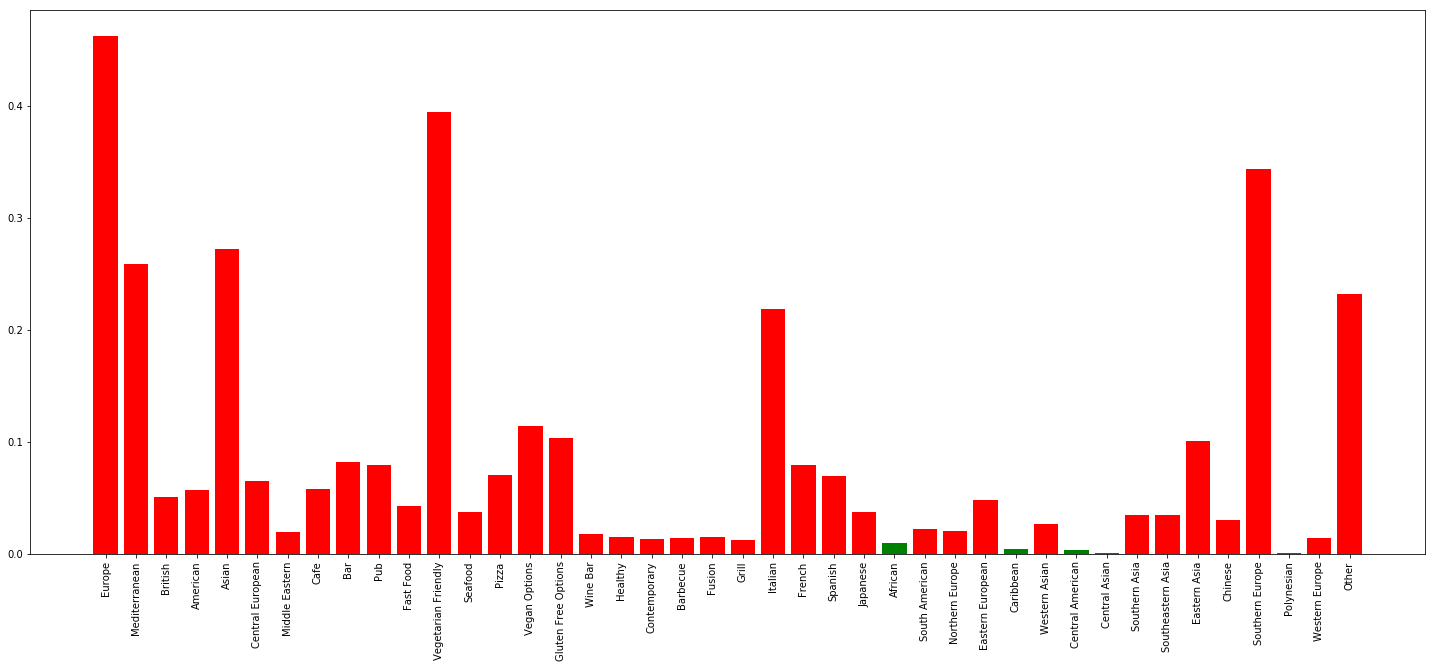

In [91]:
plt.figure(figsize=(25,10))
plt.xticks(rotation=90)
plt.bar(cuis_new_dict.keys(), cuis_new_dict.values(), color='g')
plt.bar(cuis_new_dict_sort.keys(), cuis_new_dict_sort.values(), color='r')

А дальнейшем создадим признаки, основанные на самых популярных наблюдениях.

### 1.4 Ranking

In [92]:
null_count(data.Ranking)

 Кол-во наблюдений: 50000 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 12975


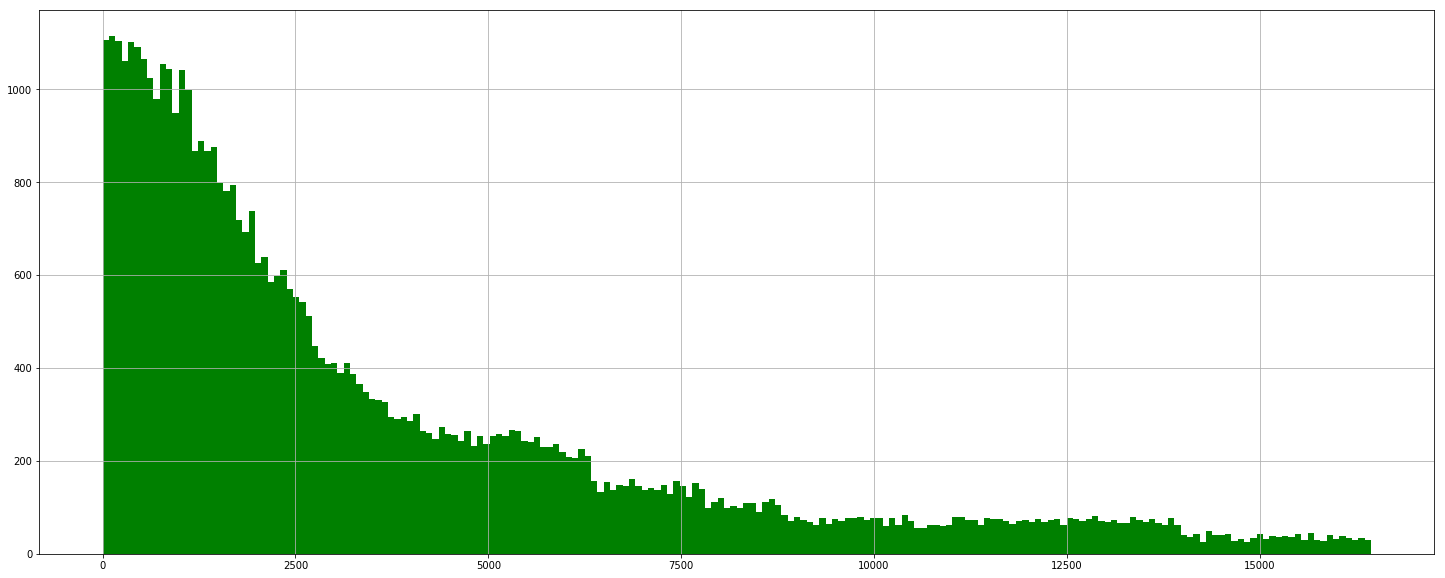

In [93]:
plt.figure(figsize=(25, 10))
data.Ranking.hist(bins=200, color='g')

Распределение признака Ranking смещено влево. Посмотрим распределение Ranking по городам.

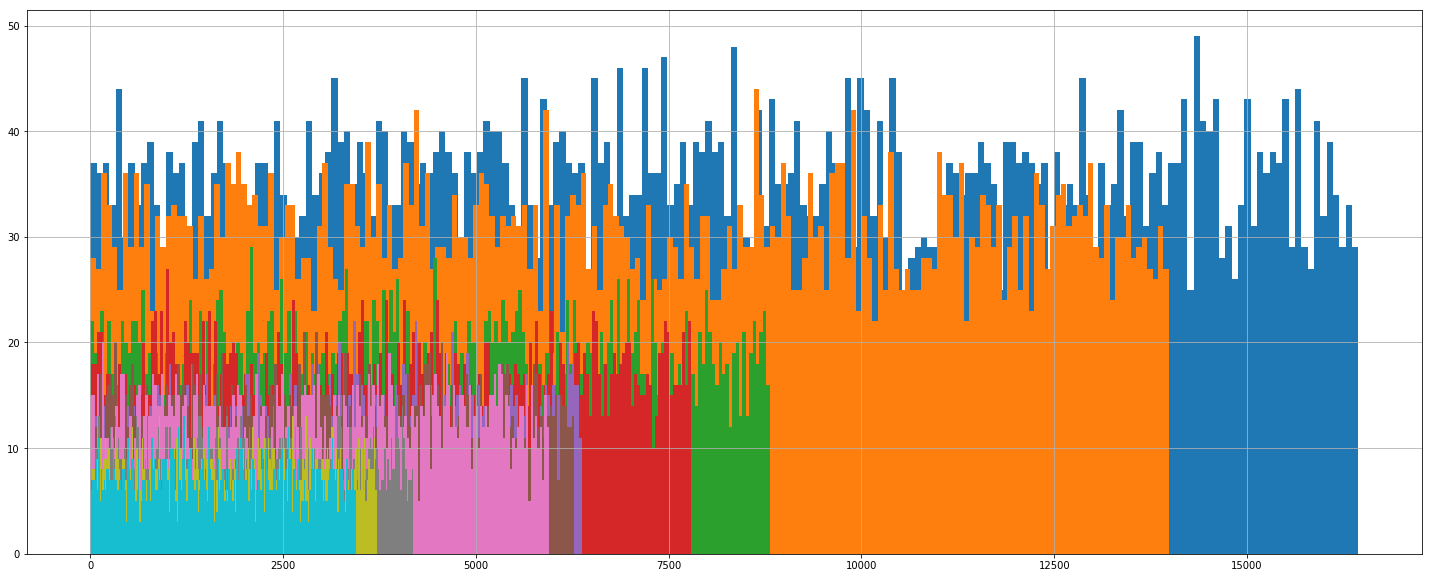

In [94]:
plt.figure(figsize=(25, 10))
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=200)
plt.show()

Как видно, в каждом городе значения признака Ranking распределены нормально. Это говорит о том, что в городах разное количество ресторанов, как следствие - разные диапазоны значений рейтинга.
Попробуем нормализовать данный признак путем нахождения отношения рейтинга ресторана в максимальному рейтингу в городе: значения признака будут лежать в одном и том же диапазоне, от 0 до 1.

In [95]:
def get_city_ranking(observation):
    """Ранг ресторана в городе"""

    if observation.City==city:
        return observation.Ranking/data[data.City==city].Ranking.max()
    else:
        return 0
def normalisation(data):
    array = np.zeros((data.City.nunique(), 50000))
    i=0
    global city
    for city in data.City.unique().tolist():
        #array[i]=preprocessing.normalize([data.apply(get_city_ranking, axis=1).tolist()])
        array[i]=data.apply(get_city_ranking, axis=1).tolist()
        i+=1
    return sum(array)
data['Ranking_norm']=normalisation(data)

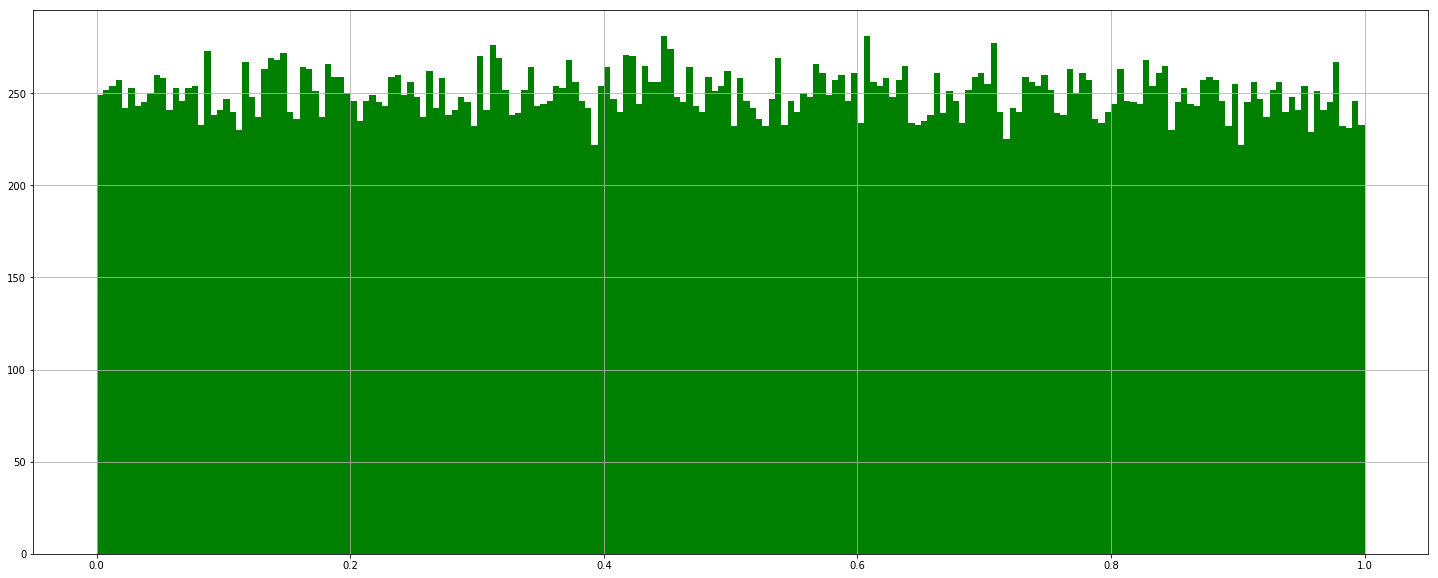

In [96]:
plt.figure(figsize=(25, 10))
data.Ranking_norm.hist(bins=200, color='g')

Как видно, признак Ranking_norm распределен нормально.

### 1.5 Rating

In [99]:
null_count(data.Rating)

 Кол-во наблюдений: 50000 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 10


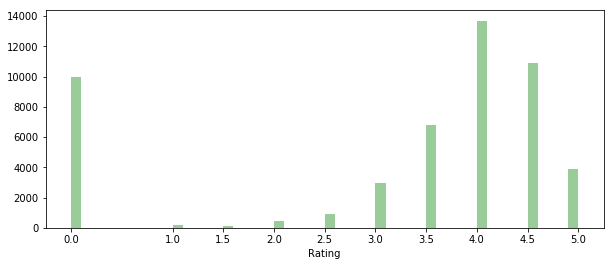

In [100]:
plt.figure(figsize=(10, 4))
plt.xticks(ticks=data.Rating.unique())
sns.distplot(data.Rating, kde=False, color='g')

Наличие нулевых значений обусловлено тестовым набором данных.

### 1.6 Price Range

In [101]:
null_count(data['Price Range'])

 Кол-во наблюдений: 50000 
 Кол-во пропущенных значений: 17361 
 Процент пропущенных значений: 35 % 
 Кол-во уникальных значений: 3


Признак содержит большое количество пропущенных значений: 35%. При этом он является порядковым. 

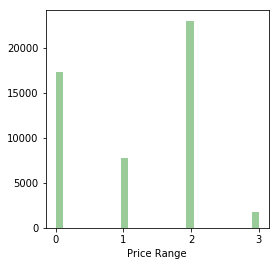

In [102]:
plt.figure(figsize=(4, 4))
price_range = data['Price Range'].apply(lambda x: 1 if x == '$'
                                        else 2 if x == '$$ - $$$'
                                        else 3 if x == '$$$$'
                                        else 0)
plt.xticks(ticks=price_range.unique())
sns.distplot(price_range, kde=False, color='g')

### 1.7 Number of Reviews

In [103]:
null_count(data['Number of Reviews'])

 Кол-во наблюдений: 50000 
 Кол-во пропущенных значений: 3200 
 Процент пропущенных значений: 6 % 
 Кол-во уникальных значений: 1573


Признак имеет 6% пропущенных значений. Посмотрим на его распределение.

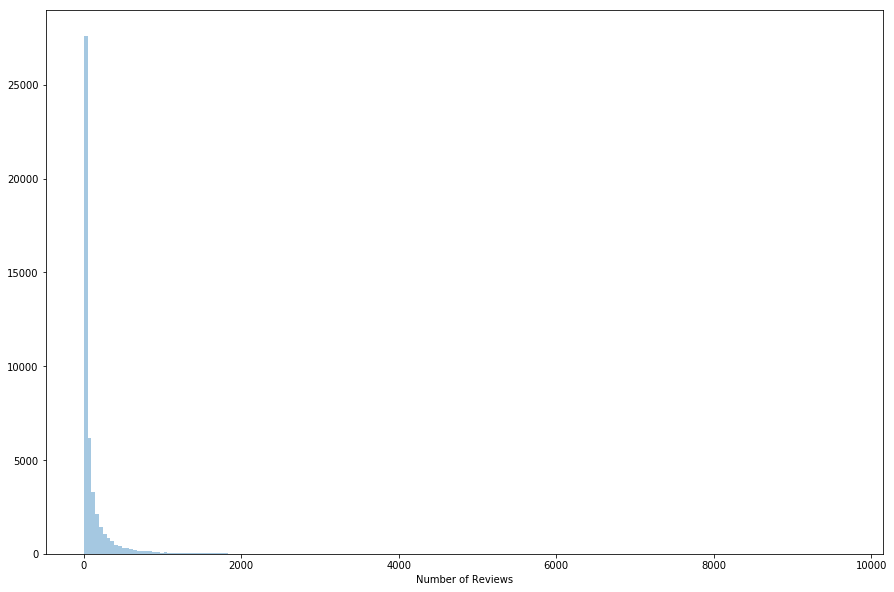

In [104]:
plt.figure(figsize=(15, 10))
sns.distplot(data['Number of Reviews'].dropna(), kde=False, bins=200)

### 1.8 Reviews

In [105]:
null_count(data['Reviews'])
data.Reviews[1]

 Кол-во наблюдений: 50000 
 Кол-во пропущенных значений: 2 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 41857


"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

### 1.9 URL_TA и ID_TA

In [106]:
null_count(data['URL_TA'])

 Кол-во наблюдений: 50000 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 49963


In [107]:
null_count(data['ID_TA'])

 Кол-во наблюдений: 50000 
 Кол-во пропущенных значений: 0 
 Процент пропущенных значений: 0 % 
 Кол-во уникальных значений: 49963


In [108]:
data['URL_TA'].value_counts().head(37)

/Restaurant_Review-g187514-d2010743-Reviews-Restaurant_Furusato-Madrid.html                                         2
/Restaurant_Review-g187514-d11674463-Reviews-Beerhouse-Madrid.html                                                  2
/Restaurant_Review-g187514-d8753348-Reviews-Tropecientos-Madrid.html                                                2
/Restaurant_Review-g187514-d3685055-Reviews-Shukran-Madrid.html                                                     2
/Restaurant_Review-g187514-d3161682-Reviews-Cerveceria_La_Surena-Madrid.html                                        2
/Restaurant_Review-g187514-d2477531-Reviews-Haya_19-Madrid.html                                                     2
/Restaurant_Review-g187514-d1568045-Reviews-Restaurante_Lateral_Santa_Ana-Madrid.html                               2
/Restaurant_Review-g187514-d7342803-Reviews-Los_Hierros-Madrid.html                                                 2
/Restaurant_Review-g187514-d7809594-Reviews-La_Guapa-Mad

## 2. Feature Engineering

### Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [109]:
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')
data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')

### 2.1 City

Создадим следующие признаки: страну, плотность населения в городе, стране, количество станций метро.

In [110]:
def get_country(city):
    """Страна"""

    if city in ['Paris', 'Lyon']:
        return 'France'
    elif city in ['Helsinki', ]:
        return 'Finland'
    elif city in ['Edinburgh']:
        return 'Scotland'
    elif city in ['London']:
        return 'England'
    elif city in ['Bratislava']:
        return 'Slovakia'
    elif city in ['Lisbon', 'Oporto']:
        return 'Portugal'
    elif city in ['Budapest']:
        return 'Hungary'
    elif city in ['Stockholm']:
        return 'Sweden'
    elif city in ['Rome', 'Milan']:
        return 'Italy'
    elif city in ['Munich', 'Hamburg', 'Berlin']:
        return 'Germany'
    elif city in ['Prague']:
        return 'Czech Republic'
    elif city in ['Vienna']:
        return 'Austria'
    elif city in['Dublin']:
        return 'Republic of Ireland'
    elif city in ['Barcelona', 'Madrid']:
        return 'Spain'
    elif city in ['Brussels']:
        return 'Belgium'
    elif city in ['Oslo']:
        return 'Norway'
    elif city in ['Amsterdam']:
        return 'Netherlands'
    elif city in ['Athens']:
        return 'Greece'
    elif city in ['Warsaw', 'Krakow']:
        return 'Poland'
    elif city in ['Copenhagen']:
        return 'Denmark'
    elif city in ['Luxembourg']:
        return 'Luxembourg'
    elif city in ['Zurich', 'Geneva']:
        return 'Switzerland'
    elif city in ['Ljubljana']:
        return 'Slovenia'


data['Country'] = data.City.apply(get_country)

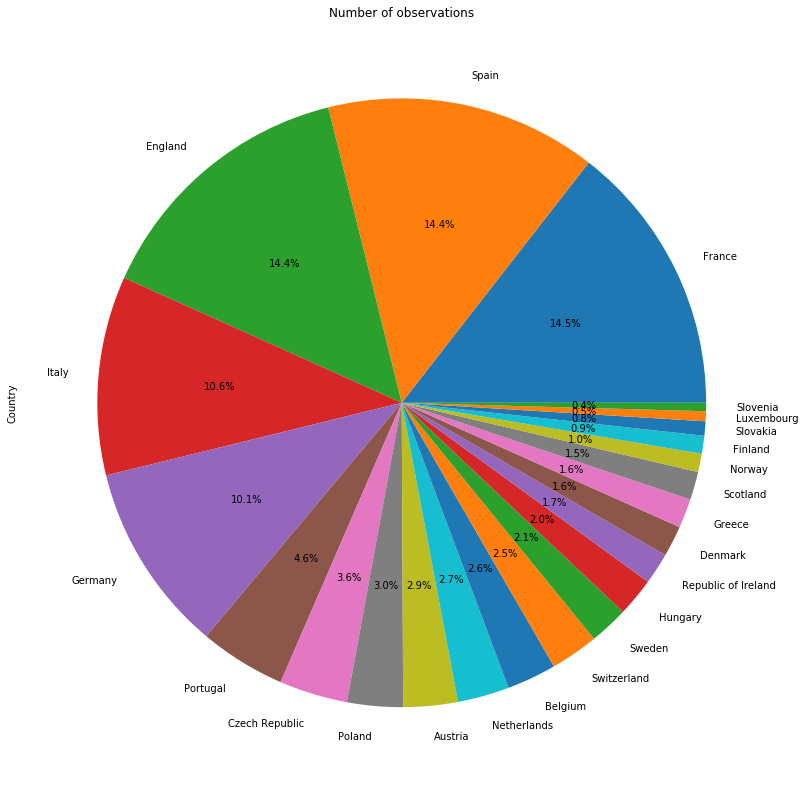

In [111]:
get_plot(data.Country)

Большинство наблюдений сосредоточены среди стран: Франция, Испания, Англия, Италия, Германия. Наблюдения в данных странах составляют 64% от общего количеста наблюдений.

In [112]:
def get_pop_dencity(city_country):
    """Плотность населения"""

    city_pop_dict = {'Paris': 20781, 'Helsinki': 899, 'Edinburgh': 4140, 'London': 5667,
                     'Bratislava': 1189, 'Lisbon': 5052.73, 'Budapest': 3330.5, 'Stockholm': 5139.7,
                     'Rome': 2234, 'Milan': 7588.97, 'Munich': 4713, 'Hamburg': 2388.57,
                     'Prague':  2506, 'Vienna': 4502.88, 'Dublin': 3689, 'Barcelona': 16302.42,
                     'Brussels': 5497, 'Madrid': 8653.5, 'Oslo': 1483.41, 'Amsterdam': 4768,
                     'Berlin': 4088, 'Lyon': 10041, 'Athens': 7500, 'Warsaw': 3449,
                     'Oporto': 5703, 'Krakow': 2344, 'Copenhagen': 6214.7, 'Luxembourg': 233.7,
                     'Zurich': 4666, 'Geneva': 12589, 'Ljubljana':  1736, 'France': 99, 'Spain': 92,
                     'England': 419.6, 'Italy': 201.1, 'Germany': 232.3, 'Portugal': 111,
                     'Czech Republic': 135.3, 'Poland': 122, 'Austria': 102.1, 'Netherlands': 405,
                     'Belgium': 368.3, 'Switzerland': 207, 'Sweden': 21.89, 'Hungary': 105,
                     'Republic of Ireland': 60.3, 'Denmark': 134.85, 'Greece': 81, 'Scotland': 69.07,
                     'Norway': 13.93, 'Finland': 16, 'Slovakia': 111, 'Luxembourg': 233.7, 'Slovenia': 101.8}
    return city_pop_dict[city_country]


data['City_pop'] = data.City.apply(get_pop_dencity)
data['Country_pop'] = data.Country.apply(get_pop_dencity)

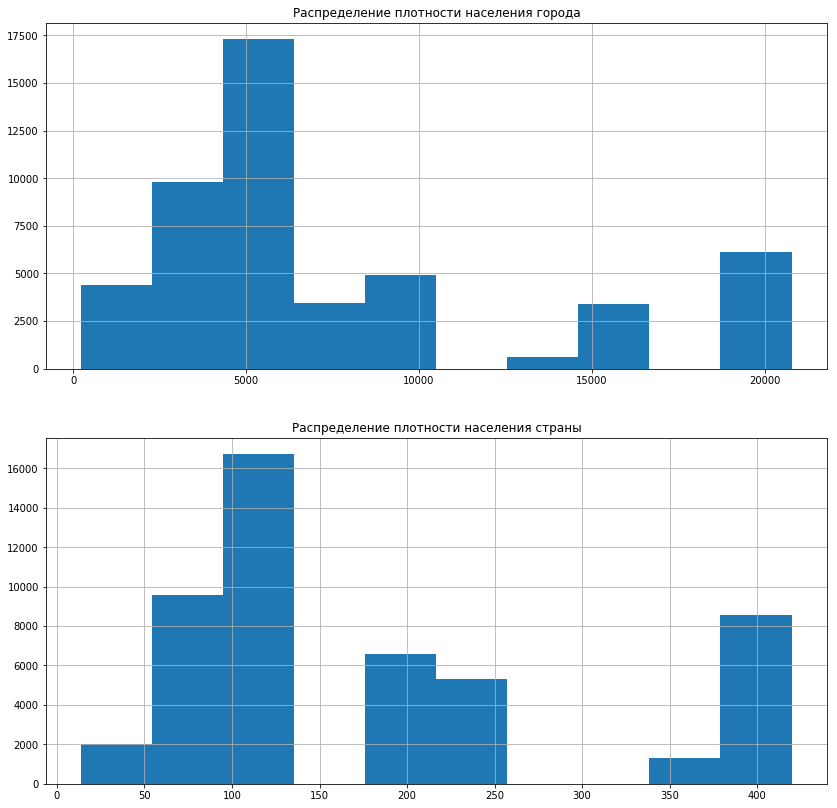

In [113]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))
ax1.set_title('Распределение плотности населения города')
data.City_pop.hist(ax=ax1)
ax2.set_title('Распределение плотности населения страны')
data.Country_pop.hist(ax=ax2)

In [114]:
def get_tourism_dencity(city_country):
    """Количество туристов"""

    tourism_dencity_dict = {'Paris': 9700000, 'Helsinki': 842000, 'Edinburgh': 1338000, 'London': 15640000,
                     'Bratislava': 455000, 'Lisbon': 1715000, 'Budapest': 2043000, 'Stockholm': 1003000,
                     'Rome': 6033000, 'Milan': 1902000, 'Munich': 1902000, 'Hamburg': 739000,
                     'Prague':  3702000, 'Vienna': 3339000, 'Dublin': 4469000, 'Barcelona': 4695000,
                     'Brussels': 179000, 'Madrid': 3921000, 'Oslo': 522000, 'Amsterdam': 3901000,
                     'Berlin': 2309000, 'Lyon': 715000, 'Athens': 2680000, 'Warsaw': 2925000,
                     'Oporto': 1600000, 'Krakow': 2732000, 'Copenhagen': 1630000, 'Luxembourg': 406000,
                     'Zurich': 1369000, 'Geneva': 577000, 'Ljubljana':  1022862,'France': 89322000, 'Spain': 82773000, 'England': 36316000, 'Italy': 61567200,
                     'Germany': 38881000, 'Portugal': 16186000, 'Czech Republic': 10611000, 'Poland': 19622000,
                     'Austria': 30816000, 'Netherlands': 18780000, 'Belgium': 9119000, 'Switzerland': 10362000,
                     'Sweden': 7440000, 'Hungary': 17552000, 'Republic of Ireland': 10926000, 'Denmark': 12749000,
                     'Greece': 30123000, 'Scotland': 11500000, 'Norway': 5688000, 'Finland': 3224000,
                     'Slovakia': 2256000, 'Luxembourg': 1018000, 'Slovenia': 4425000}
    return tourism_dencity_dict[city_country]

data['Country_tourism_dencity'] = data.Country.apply(get_tourism_dencity)
data['City_tourism_dencity'] = data.City.apply(get_tourism_dencity)

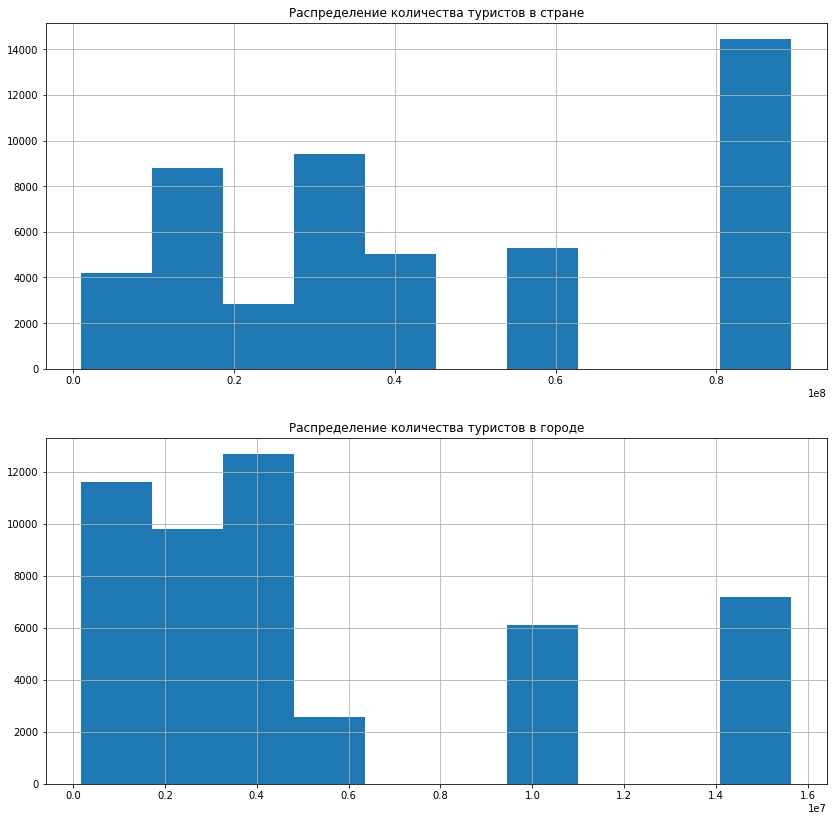

In [115]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))
ax1.set_title('Распределение количества туристов в стране')
data.Country_tourism_dencity.hist(ax=ax1)
ax2.set_title('Распределение количества туристов в городе')
data.City_tourism_dencity.hist(ax=ax2)

In [116]:
def get_metropolitan_stations(city):
    """Плотность населения"""

    metropolitan_stations_dict = {'Paris': 383, 'Helsinki': 25, 'Edinburgh': 0, 'London': 315,
                     'Bratislava': 0, 'Lisbon': 56, 'Budapest': 52, 'Stockholm': 100,
                     'Rome': 73, 'Milan': 113, 'Munich': 100, 'Hamburg': 92,
                     'Prague':  61, 'Vienna': 109, 'Dublin': 14, 'Barcelona': 187,
                     'Brussels': 59, 'Madrid': 302, 'Oslo': 101, 'Amsterdam': 39,
                     'Berlin': 173, 'Lyon': 40, 'Athens': 61, 'Warsaw': 34,
                     'Oporto': 81, 'Krakow': 0, 'Copenhagen': 37, 'Luxembourg': 0,
                     'Zurich': 0, 'Geneva': 0, 'Ljubljana':  0}
    return metropolitan_stations_dict[city]

data['Metropolitan_stations'] = data.City.apply(get_metropolitan_stations)

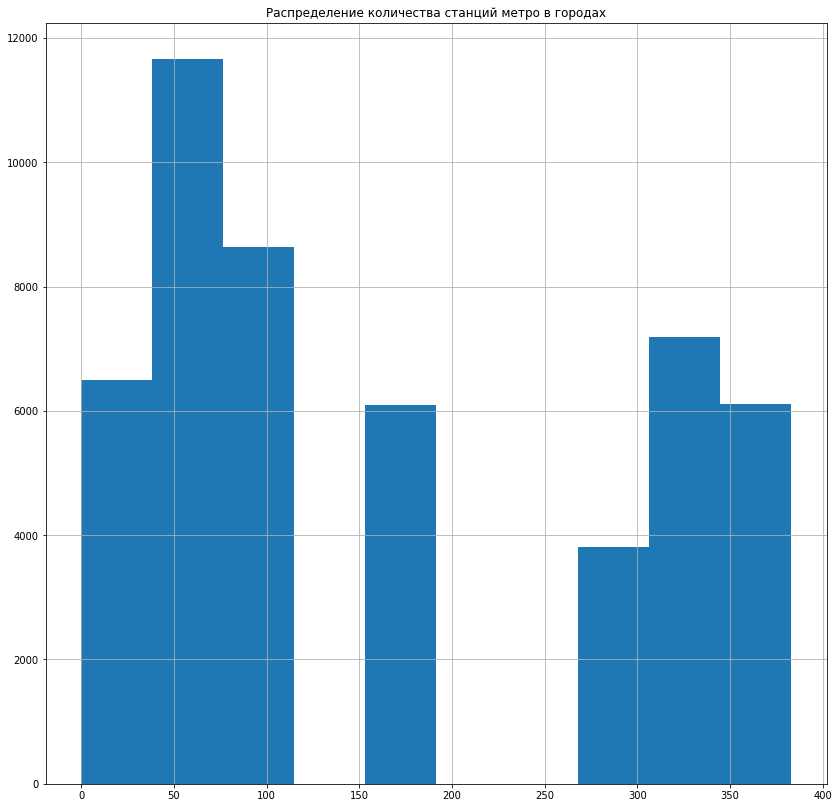

In [117]:
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 14))
ax1.set_title('Распределение количества станций метро в городах')
data.Metropolitan_stations.hist(ax=ax1)

## 2.2 Cuisine Style
Создадим признаки самых популярных видов кухонь.

In [118]:
def one_hot_encoding(cuislist, key):
    '''Вывод признаков - видов кухонь'''

    if type(cuislist) == float:
        return 0
    else:
        i = 0
        for cuis_value in cuis_corr_dict[one_hot_encoding_dict[key]]:
            if cuis_value in cuislist[2:-2].split('\', \''):
                return 1
            else:
                i += 1
                if i == len(cuis_corr_dict[one_hot_encoding_dict[key]]):
                    return 0


one_hot_encoding_dict = {0: 'Europe', 1: 'Mediterranean', 2: 'British', 3: 'American', 4: 'Asian', 5: 'Central European',
                         6: 'Middle Eastern', 7: 'Cafe', 8: 'Bar', 9: 'Pub', 10: 'Fast Food', 11: 'Vegetarian Friendly',
                         12: 'Seafood', 13: 'Pizza', 14: 'Vegan Options', 15: 'Gluten Free Options', 16: 'Wine Bar',
                         17: 'Healthy', 18: 'Contemporary', 19: 'Barbecue', 20: 'Fusion', 21: 'Grill', 22: 'Italian',
                         23: 'French', 24: 'Spanish', 25: 'Japanese', 26: 'South American', 27: 'Northern Europe',
                         28: 'Eastern European', 29: 'Western Asian', 30: 'Southern Asia', 31: 'Southeastern Asia',
                         32: 'Eastern Asia', 33: 'Southern Europe', 34: 'Western Europe', 35: 'Other'}
for cuis_key in one_hot_encoding_dict:
    data['Cuisine '+one_hot_encoding_dict[cuis_key]
         ] = data['Cuisine Style'].apply(one_hot_encoding, key=cuis_key)

## 2.3 Reviews
Выведем новые признаки: количество положительных отзывов, даты последнего и предпоследнего отзывов.

In [ ]:
def get_review_date(reviews, max_min):
    '''Вывод дат отзывов'''

    if pd.isnull(reviews) == True:
        return None
    else:
        date_values = re.findall(r'\d+/\d+/\d+', reviews)
        if len(date_values) == 0:
            return None
        else:
            date_list = []
            for date in date_values:
                if int(date.split('/')[0]) <= 12 and len(date.split('/')[2]) == 2:
                    date_list.append(datetime.strptime(date, '%m/%d/%y'))
                elif int(date.split('/')[0]) <= 12 and len(date.split('/')[2]) == 4:
                    date_list.append(datetime.strptime(date, '%m/%d/%Y'))
                elif int(date.split('/')[0]) > 12 and len(date.split('/')[2]) == 2:
                    date_list.append(datetime.strptime(date, '%d/%m/%y'))
                elif int(date.split('/')[0]) > 12 and len(date.split('/')[2]) == 4:
                    date_list.append(datetime.strptime(date, '%d/%m/%Y'))
            if max_min == 0:
                return min(date_list)
            else:
                return max(date_list)


data['Last_date'] = data.Reviews.apply(get_review_date, max_min=0)
data['Second-to-last_date'] = data.Reviews.apply(get_review_date, max_min=1)

In [120]:
def get_review_rating(reviews):
    '''Вывод количества позитивных отзывов'''
    
    
    positive_list = ['good', 'fine', 'better', 'exquisite', 'delicious', 'best',
                     'quick', 'great', 'style', 'welcome', 'cozy', 'surprisingly', 'yummy', 'nice', 'truly',
                     'expected', 'decent', 'joy', 'atmosphere', 'amazing', 'loved', 'friendly', 'fahion',
                     'spectacular', 'tasty', 'impeccable', 'like', 'pleasant', 'fantastic', 'high', 'quality',
                     'satisfaction', 'atmos', 'surprise', 'magnificent', 'superb', 'elegant', 'approachable',
                     'excellent', 'highly', 'recommended', 'definitely', 'improved', 'creative', 'atmoshere',
                     'perfect', 'outstanding', 'pat', 'right', 'favourite', 'awesome', 'relaxing', 'well',
                     'gem', 'wonderful', 'beautiful', 'lots', 'variety', 'fun', 'enjoy', 'relax', 'funny', 'delightful',
                     'promising', 'dry', 'treasure', 'convenient', 'passion', 'relaxed', 'tasteful', 'enjoyable',
                     'fab', 'super', 'okay', 'reasonable', 'affordable', 'proper', 'exellent', 'welcoming', 'ambience',
                     'clean', 'kosher', 'fabulous', 'charm', 'fresh', 'comfort', 'heaven', 'really', 'appealing', 'warmness',
                     'love', 'satisfying', 'pleasure', 'interesting', 'armospher', 'modern', 'friend', 'glad', 'friendl',
                     'easy', 'mindful', 'handy', 'healthy', 'favorite', 'consistent',
                     'inexpensive', 'prettiest', 'bland', 'juicy', 'generously', 'stale', 'amazingly', 'especially',
                     'galore', 'wonderfull', 'comfortable', 'unbeatable', 'enjoying', 'efficient', 'champions',
                     'impressed', 'yum', 'beauty', 'unusual', 'enjoyed', 'breathtaking', 'unique', 'tart', 'recommendation',
                     'tastiest', 'impressive', 'brilliant', 'ruby', 'recommend', 'pretty', 'atmospher', 'exprimental',
                     'harmony', 'symphony', 'súper', 'delcious', 'terrific', 'spacious', 'rude', 'assured', 'succulent']
    negative_list = ['pricey', 'break', 'slow', 'pretentious', 'disappointing', 'middle', 'nothing', 'old', 'nightmare',
                     'disap', 'lazy', 'worthy', 'expensive', 'worst', 'bad', 'low', 'quirky',
                     'little', 'hidden', 'worth', 'serve', 'sad', 'conmen', 'confused', 'rotten', 'average',
                     'overpriced', 'awful', 'poor', 'ugly', 'greasy', 'busy', 'chaotic', 'odd', 'deafening', 'noise',
                     'moldy', 'disgusting', 'rubbish', 'unpredictable', 'rip', 'horribl', 'wrong', 'unconvincing',
                     'questionable', 'extortionate', 'ravel', 'true', 'kick', 'awkward', 'waste', 'expensiv',
                     'sadly', 'missed', 'funky', 'terrible', 'uninspiring', 'unclear', 'chill', 'dull', 'tired',
                     'shame', 'shameful', 'disapponiting', 'hype', 'unorganized', 'beware', 'scam', 'scarce',
                     'stupido']
    pos_sum = 0
    if pd.isnull(reviews) == True:
        return 0
    else:
        for review in reviews.split('], [')[0][2:].split('\', \''):
            pos_num = 0
            neg_num = 0
            for word in re.findall(r'\w+', review):
                if word.lower() in positive_list:
                    pos_num += 1
                elif word.lower() in negative_list:
                    neg_num += 1
            if pos_num + neg_num == 0:
                continue
            elif pos_num + neg_num == pos_num:
                pos_sum += 1
        # return [pos_sum,reviews]
        return pos_sum


data['Number_of_positive_reviews'] = data.Reviews.apply(get_review_rating)

## 2.4 Price Range
Так как признак Price Range порядковый, преобразуем его в числовой формат. Пропущенным значениям присвоим среднюю ценовую категорию.

In [121]:
data['Price Range'] = data['Price Range'].apply(lambda x: 1 if x == '$'
                                                else 2 if x == '$$ - $$$'
                                                else 3 if x == '$$$$'
                                                else 2)

## 2.5 One-Hot Encoding

In [123]:
data = pd.get_dummies(data, columns=[ 'City','Country'], dummy_na=False)

## 2.6 Удаление признаков типа object

In [128]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [138]:
data.drop(['Last_date','Second-to-last_date'], axis=1, inplace=True)

## 2.7 Number of Reviews

In [145]:
data['Number of Reviews'].fillna(data['Number of Reviews'].mean(), inplace=True)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

# Model 
Сам ML

In [146]:
data.head()

,Restaurant_id,Ranking,Price Range,Number of Reviews,sample,Rating,Ranking_norm,Number_of_Reviews_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,...,Country_Norway,Country_Poland,Country_Portugal,Country_Republic of Ireland,Country_Scotland,Country_Slovakia,Country_Slovenia,Country_Spain,Country_Sweden,Country_Switzerland
0,0,12963.0,2,4.0,0,0.0,0.926855,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,106.0,2,97.0,0,0.0,0.092901,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,810.0,2,28.0,0,0.0,0.458664,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,3,1669.0,3,202.0,0,0.0,0.101496,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,37.0,3,162.0,0,0.0,0.041620,0,0,0,...,0,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


MAE: 0.17275


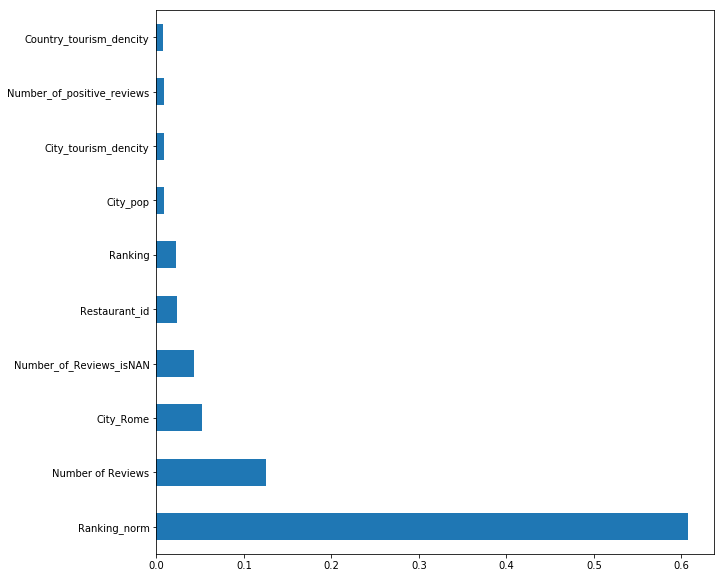

In [148]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)
y = train_data.Rating.values# наш таргет
X = train_data.drop(['Rating'], axis=1)
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = np.round(model.predict(X_test)*2)/2
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [64]:
test_data.sample(10)

NameError: name 'test_data' is not defined

In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)